In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import stats
from scipy.optimize import curve_fit
path = 'Dils_Luca/Dils_Luca'

In [60]:
'''
https://www.dropbox.com/scl/fo/sbrys0mdgpxeqotm57sg6/AEnV65s46W_jdwOhBBFqLyI?rlkey=n01qpo6pzp3q2fydrrqiamlxo&st=2bv1hmhd&dl=0'
'''

"\nhttps://www.dropbox.com/scl/fo/sbrys0mdgpxeqotm57sg6/AEnV65s46W_jdwOhBBFqLyI?rlkey=n01qpo6pzp3q2fydrrqiamlxo&st=2bv1hmhd&dl=0'\n"

In [61]:
# Magnetfeld einer Leiterschleife auf der z-Achse
def magnetic_field_n_coils(R, I, z, d, n):
    mu_0 = 4 * np.pi * 1e-7  # Magnetische Feldkonstante in N/A^2
    B_total = np.zeros_like(z)
    
    # Summe der Magnetfelder der n übereinander gestapelten Leiterschleifen
    for i in range(n):
        z_i = z - i * d
        B_total += (mu_0 * I * R**2) / (2 * (R**2 + z_i**2)**(3/2))
    
    return B_total

# Plotten des Magnetfeldes über z
def plot_magnetic_field(R, I, d, n, z_min, z_max, num_points):
    z_values = np.linspace(z_min, z_max, num_points)
    B_values = magnetic_field_n_coils(R, I, z_values, d, n)
    
    plt.figure(figsize=(8, 6))
    plt.plot(z_values, B_values, label=f'R={R} m, I={I} A, d={d} m, n={n}')
    plt.title('Magnetfeld entlang der z-Achse für n Leiterschleifen')
    plt.xlabel('z (m)')
    plt.ylabel('B (T)')
    #plt.grid(True)
    plt.legend()
    plt.show()




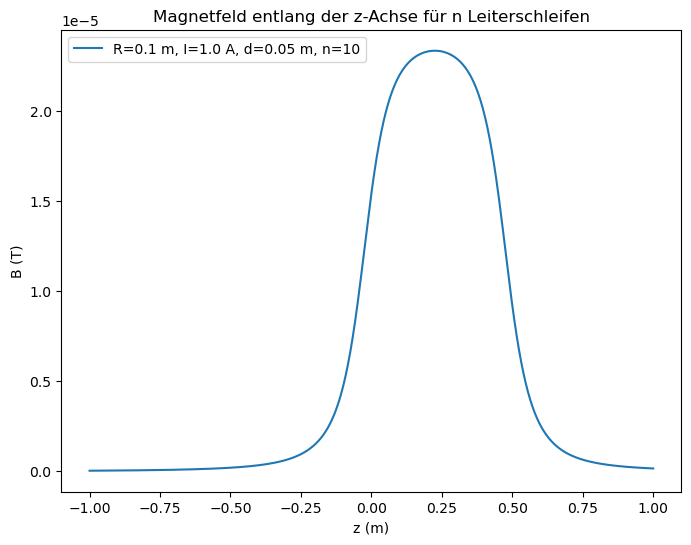

In [62]:
# Beispielaufruf für die Funktion mit parametern
R = 0.1  # Radius in Metern
I = 1.0  # Strom in Ampere
d = 0.05  # Abstand zwischen den Leiterschleifen in Metern
n = 10    # Anzahl der Leiterschleifen
z_min = -1.0  # z-Bereich Minimum in Metern
z_max = 1.0   # z-Bereich Maximum in Metern
num_points = 1000  # Anzahl der Punkte auf der z-Achse

plot_magnetic_field(R, I, d, n, z_min, z_max, num_points)

In [63]:
def t_below(pressure):
    A = [1.392408,0.527153,0.166756,0.050988,0.026514,0.001975,-0.017976,0.005409,0.013259,0]
    B = 5.6
    C = 2.9

    sum = A[0]
    for i in range(1,10):
        sum = sum+A[i]*((np.log(pressure)-B)/C)**i
    return sum
def t_above(pressure):
    A = [3.146631,1.357655,0.413923,0.091159,0.016349,0.001826,-0.004325,-0.004973,0,0]
    B = 10.3
    C = 1.9

    sum = A[0]
    for i in range(1,10):
        sum = sum+A[i]*((np.log(pressure)-B)/C)**i
    return sum
def t_calc(pressure):
    # Verwende np.where, um für jedes Element des pressure-Arrays die passende Funktion aufzurufen
    result = np.where(pressure >= 5036, t_above(pressure), t_below(pressure))
    return result

def calculate_temperature_above(R, R0, T0):
    # Prüfen, ob der Widerstand sinnvoll ist
    if R <= 0 or R0 <= 0:
        raise ValueError("Widerstandswerte müssen größer als 0 sein.")
    
    # Temperatur berechnen
    T = T0 / np.log(R / R0)
    return T
def calculate_x_for_y(y_value, a, b):
    if y_value <= 0 or a <= 0:
        raise ValueError("y-Werte und a müssen größer als 0 sein.")
    
    x_value = np.log(y_value / a) / b
    return x_value

def calculate_temperature(U_AB, R0, T0):
    """Berechnet die Temperatur T aus den gemessenen Spannungswerten U_AB 
    basierend auf der exponentiellen Widerstandsfunktion."""
    return T0 / np.log(U_AB / R0)

In [64]:
# Berechnung des Magnetfelds B mit der gegebenen Gleichung
def calculate_magnetic_field(N, I, r_0, r_i, L):
    term_0 = r_0 + np.sqrt(r_0**2 + (L**2 / 2**2))
    term_i = r_i + np.sqrt(r_i**2 + (L**2 / 2**2))
    B = (1/2) * (N * I / (r_0 - r_i)) * np.log(term_0 / term_i)
    
    return B

# Beispielaufruf für die Funktion mit parametern
N = 100  # Anzahl der Windungen
I = 1.0  # Strom in Ampere
r_0 = 0.1  # äußerer Radius in Metern
r_i = 0.05  # innerer Radius in Metern
L = 0.2  # Länge der Spule in Metern

B_result = calculate_magnetic_field(N, I, r_0, r_i, L)
B_result



400.16176195993955

In [65]:
def read_dat_file(file_path):
    """
    Liest eine .dat-Datei ein, überspringt den Metatext und gibt die Daten zurück.
    
    :param file_path: Pfad zur .dat-Datei
    :return: Pandas DataFrame mit den eingelesenen Daten
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Finde heraus, wo die letzte Zeile des Metatexts "Kommentar:" ist
    for i, line in enumerate(lines):
        if "Kommentar:" in line:
            data_start = i + 1  # Die Daten starten nach dieser Zeile
            break

    # Lese die Daten ab der gefundenen Zeile ein
    data = pd.read_csv(file_path, skiprows=data_start, delim_whitespace=True, decimal=',')
    
    return data

def list_dat_files(directory):
    """
    Gibt eine Liste aller .dat-Dateien in einem Verzeichnis zurück.
    
    :param directory: Verzeichnis, in dem nach .dat-Dateien gesucht wird
    :return: Liste der .dat-Dateien
    """
    return [file for file in os.listdir(directory) if file.endswith('.dat')]
def list_csv_files(directory):
    """
    Gibt eine Liste aller .dat-Dateien in einem Verzeichnis zurück.
    
    :param directory: Verzeichnis, in dem nach .dat-Dateien gesucht wird
    :return: Liste der .dat-Dateien
    """
    return [file for file in os.listdir(directory) if file.endswith('.csv')]

# Beispiel-Nutzung:
# daten = read_dat_file('path/to/deine_datei.dat')
# dat_dateien = list_dat_files('path/to/dein_verzeichnis')


In [66]:
os.getcwd()

'c:\\Users\\lucas\\Documents\\Python Scripts\\supraconductivity'

Steigung: 1051.2079257071405 ± 0.49382037587628647
Steigung: 0.046976470001793114%
y-Achsenabschnitt: -1.415862197766389 ± 0.25272727200126055
Steigung: -17.849708283754843%


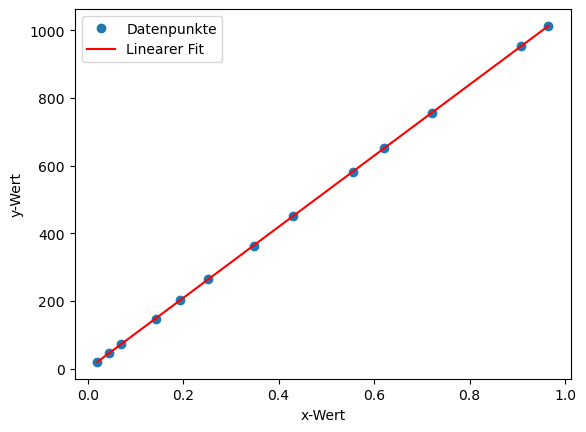

In [67]:
#### Manometer Calibration

y_values = [1013,954, 757, 651, 581, 452, 363, 264, 202, 148, 73,45,20]
x_values = [0.96479, 0.908769,0.720989,0.621066, 0.555067,0.430496, 0.347281, 0.252041, 0.193711, 0.142460,0.0706393, 0.0441227,0.0200334]
x_values = np.array(x_values)
y_values = np.array(y_values)

# Lineare Regression mit Fehlerabschätzung
popt, pcov = np.polyfit(x_values, y_values, 1, cov=True)

# Parameter
slope = popt[0]        # Steigung
intercept = popt[1]     # y-Achsenabschnitt

# Fehler (Standardabweichungen der Parameter)
slope_err = np.sqrt(pcov[0, 0])      # Fehler der Steigung
intercept_err = np.sqrt(pcov[1, 1])  # Fehler des y-Achsenabschnitts

# Ergebnisse anzeigen
print(f"Steigung: {slope} ± {slope_err}")
print(f"Steigung: {slope_err/slope*100}%")
print(f"y-Achsenabschnitt: {intercept} ± {intercept_err}")
print(f"Steigung: {intercept_err/intercept*100}%")

# Fit-Linie
fit_line = slope * x_values + intercept

# Plot
plt.plot(x_values, y_values, 'o', label='Datenpunkte')
plt.plot(x_values, fit_line, 'r', label='Linearer Fit')
plt.xlabel('x-Wert')
plt.ylabel('y-Wert')
plt.legend()
plt.show()


In [68]:
dat_dateien = list_dat_files(path)
dat_dateien[2]
df = read_dat_file(path+'/'+dat_dateien[0])
col_names = ['Zeit/s', 'U_AB (V)', 'U_mano (V)', 'U_sample (V)', 'U_field (V)']
df = df.iloc[:, :5]
df.columns = col_names[:5]

df
#dat_dateien

,Zeit/s,U_AB (V),U_mano (V),U_sample (V),U_field (V)
0,0.0,0.009162,0.961004,0.000181,8.200000e-07
1,1.0,0.009162,0.961041,0.000181,7.890000e-07
2,2.0,0.009161,0.961073,0.000181,7.160000e-07
3,3.0,0.009161,0.961084,0.000181,4.150000e-07
4,4.0,0.009161,0.961078,0.000181,7.470000e-07
...,...,...,...,...,...
1371,1371.0,0.122095,0.000645,0.000078,4.200000e-08
1372,1372.0,0.122122,0.000652,0.000077,-3.100000e-08
1373,1373.0,0.122153,0.000676,0.000078,1.970000e-07
1374,1374.0,0.122149,0.000672,0.000078,1.870000e-07


In [69]:
dat_dateien = list_dat_files(path)
for element in dat_dateien:
    df = read_dat_file(path+'/'+element)
    col_names = ['Zeit/s', 'U_AB (V)', 'U_mano (V)', 'U_sample (V)', 'U_field (V)']
    df = df.iloc[:, :5]
    df.columns = col_names[:5]
    df['U_AB (V) error'] = df['U_AB (V)'].values*0.000050+0.1*0.000035
    df['U_mano (V) error'] = df['U_mano (V)'].values*0.000050+0.1*0.000035
    df['U_sample (V) error'] = df['U_sample (V)'].values*0.000050+0.1*0.000035
    df['U_field (V) error'] = df['U_field (V)'].values*0.000050+0.1*0.000035
    df['pressure_manometer/Pascal'] = df['U_mano (V)'].values*slope*100
    df['temp_manometer/K'] = t_calc(df['pressure_manometer/Pascal'])
    df['pressure_manometer error/Pascal'] = (df['U_mano (V) error'].values*slope*100+0.01)*1.03
    df['temp_manometer_lower/K'] = t_calc(df['pressure_manometer/Pascal']-df['pressure_manometer error/Pascal'])
    df['temp_manometer_upper/K'] = t_calc(df['pressure_manometer/Pascal']+df['pressure_manometer error/Pascal'])
    df['R_AB (Ohm)'] = df['U_AB (V)'].values/(10**(-6))
    df['R_AB (Ohm) error'] = df['U_AB (V) error'].values/(10**(-6))

    
    #plt.plot(df['Zeit/s'], df['temp_manometer/K'])
    #plt.show()
    df.to_csv('data_preprocessed/'+element[:-3]+'csv', index=False)


(0.0, 5.0)

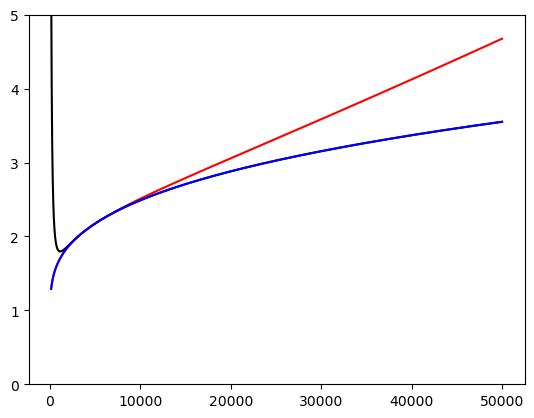

In [70]:
pressure_example = np.linspace(150,50000,200000)
plt.plot(pressure_example, t_below(pressure_example), c='red')
plt.plot(pressure_example, t_above(pressure_example), c='black')
plt.plot(pressure_example, t_calc(pressure_example), c='blue')
plt.ylim(0,5)

## Allan Bradley Resistor Calibration

In [71]:
###Kalibration Allan Bradley resistor
csv_files = list_csv_files('data_preprocessed/')
df = pd.read_csv('data_preprocessed/'+csv_files[0])
df.head()

,Zeit/s,U_AB (V),U_mano (V),U_sample (V),U_field (V),U_AB (V) error,U_mano (V) error,U_sample (V) error,U_field (V) error,pressure_manometer/Pascal,temp_manometer/K,pressure_manometer error/Pascal,temp_manometer_lower/K,temp_manometer_upper/K,R_AB (Ohm),R_AB (Ohm) error
0,0.0,0.009162,0.961004,0.000181,8.200000e-07,0.000004,0.000052,0.000004,0.000004,101021.460095,4.218911,5.591866,4.218852,4.218970,9161.512,3.958076
1,1.0,0.009162,0.961041,0.000181,7.890000e-07,0.000004,0.000052,0.000004,0.000004,101025.429456,4.218953,5.592070,4.218894,4.219012,9161.566,3.958078
2,2.0,0.009161,0.961073,0.000181,7.160000e-07,0.000004,0.000052,0.000004,0.000004,101028.754427,4.218988,5.592241,4.218929,4.219047,9160.742,3.958037
3,3.0,0.009161,0.961084,0.000181,4.150000e-07,0.000004,0.000052,0.000004,0.000004,101029.933882,4.219000,5.592302,4.218941,4.219059,9160.612,3.958031
4,4.0,0.009161,0.961078,0.000181,7.470000e-07,0.000004,0.000052,0.000004,0.000004,101029.311567,4.218994,5.592270,4.218935,4.219052,9160.731,3.958037


In [72]:
# 1. Daten filtern
filtered_df1 = df[df['temp_manometer/K'] >= 2.1768]
filtered_df2 = df[df['temp_manometer/K'] < 2.1768]


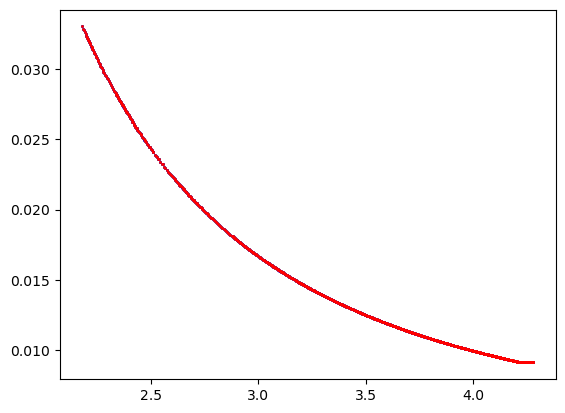

In [73]:
plt.scatter(filtered_df1['temp_manometer/K'], filtered_df1['U_AB (V)'], s=1, c='black')
plt.scatter(filtered_df1['temp_manometer_lower/K'], filtered_df1['U_AB (V)'], s=1, c='blue')
plt.scatter(filtered_df1['temp_manometer_upper/K'], filtered_df1['U_AB (V)'], s=1, c='red')

Fit-Parameter: R0 = 0.0023392461291599736, T0 = 5.834571632271391
Fehler: R0_error = 4.725322955386375e-06, T0_error = 0.005702436721049825


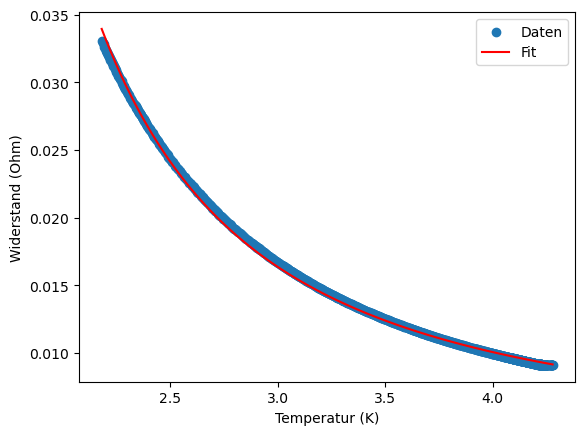

0.20200195680491495
0.09773531084114692


In [74]:

# Exponentielle Funktion für den Widerstand
def resistance_func(T, R0, T0):
    return R0 * np.exp(T0 / T)

# Temperatur- und Widerstandsdaten extrahieren
x_data = filtered_df1['temp_manometer/K'].values
y_data = filtered_df1['U_AB (V)'].values

# Fit an die Daten
params, cov_matrix = curve_fit(resistance_func, x_data, y_data)

# Parameter und Kovarianzmatrix ausgeben
R0, T0 = params
param_errors = np.sqrt(np.diag(cov_matrix))
print(f"Fit-Parameter: R0 = {R0}, T0 = {T0}")
print(f"Fehler: R0_error = {param_errors[0]}, T0_error = {param_errors[1]}")

# Fit plotten
plt.scatter(x_data, y_data, label='Daten')
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = resistance_func(x_fit, R0, T0)
plt.plot(x_fit, y_fit, label='Fit', color='red')
plt.xlabel('Temperatur (K)')
plt.ylabel('Widerstand (Ohm)')
plt.legend()
plt.show()
print(param_errors[0]/R0*100)
print(param_errors[1]/T0*100)

In [75]:
# upper and lower bound 
# Exponentielle Funktion für den Widerstand
def resistance_func(T, R0, T0):
    return R0 * np.exp(T0 / T)

# Temperatur- und Widerstandsdaten extrahieren
x_data = filtered_df1['temp_manometer_lower/K'].values
y_data = filtered_df1['U_AB (V)'].values

# Fit an die Daten
params_lower, cov_matrix = curve_fit(resistance_func, x_data, y_data)

# Parameter und Kovarianzmatrix ausgeben
R0_lower, T0_lower = params_lower

# Exponentielle Funktion für den Widerstand
def resistance_func(T, R0, T0):
    return R0 * np.exp(T0 / T)

# Temperatur- und Widerstandsdaten extrahieren
x_data = filtered_df1['temp_manometer_upper/K'].values
y_data = filtered_df1['U_AB (V)'].values

# Fit an die Daten
params_upper, cov_matrix = curve_fit(resistance_func, x_data, y_data)

# Parameter und Kovarianzmatrix ausgeben
R0_upper, T0_upper = params_upper

R0_delta = max(abs(R0-R0_lower), abs(R0-R0_upper))
T0_delta = max(abs(T0-T0_lower), abs(T0-T0_upper))
print(f"Fit-Parameter: R0 = {R0}, T0 = {T0}")
print(f"Fit-Parameter: R0 = {R0_lower}, T0 = {T0_lower}")
print(f"Fit-Parameter: R0 = {R0_upper}, T0 = {T0_upper}")
print(f"Fit-Parameter: R0_delta = {R0_delta}, T0_delta = {T0_delta}")

Fit-Parameter: R0 = 0.0023392461291599736, T0 = 5.834571632271391
Fit-Parameter: R0 = 0.002339312441405571, T0 = 5.834386407570388
Fit-Parameter: R0 = 0.0023391798291592368, T0 = 5.834756840571596
Fit-Parameter: R0_delta = 6.631224559738857e-08, T0_delta = 0.0001852247010027952


In [76]:
#temperature = calculate_temperature(0.009162, R0, T0)
#temperature

Exponentielle Fit-Parameter: a = 0.5568841239487226, b = -1.2830484893796361


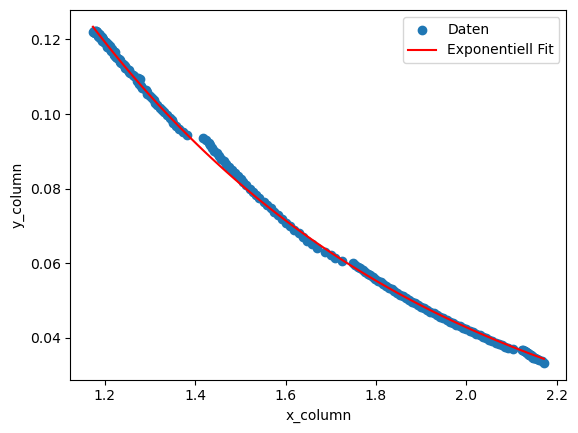

In [77]:
# 2. Exponentielle Funktion
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Fitte verschiedene Modelle
x_data = filtered_df2['temp_manometer/K'].values
y_data = filtered_df2['U_AB (V)'].values

# Exponentielles Modell fitten
exp_params, _ = curve_fit(exp_func, x_data, y_data)
print(f"Exponentielle Fit-Parameter: a = {exp_params[0]}, b = {exp_params[1]}")


# Visualisierung der Fitted Models
plt.scatter(x_data, y_data, label='Daten')

x_fit = np.linspace(min(x_data), max(x_data), 100)

# Exponentielles Modell plotten
plt.plot(x_fit, exp_func(x_fit, *exp_params), label='Exponentiell Fit', color='red')


plt.xlabel('x_column')
plt.ylabel('y_column')
plt.legend()
plt.show()


Fit-Parameter: a = 0.5568841239487226, b = -1.2830484893796361
Fehler: a_error = 0.0020192149041595533, b_error = 0.0027169859151251557


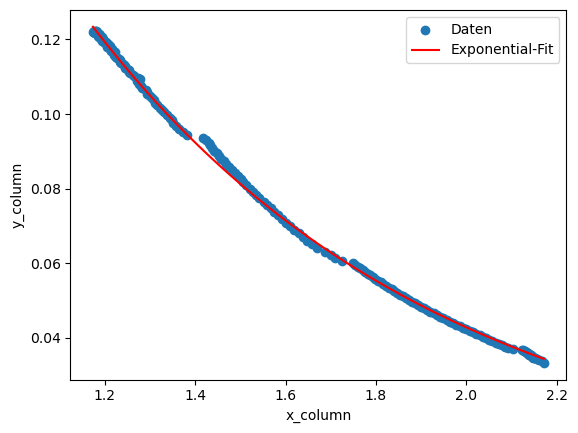

In [78]:
# Exponentielle Funktion definieren: y = a * exp(b * x)
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Daten extrahieren

x_data = filtered_df2['temp_manometer/K'].values
y_data = filtered_df2['U_AB (V)'].values

# Fit der Exponentialfunktion an die Daten
params, cov_matrix = curve_fit(exp_func, x_data, y_data)

# Fit-Parameter und Kovarianzmatrix ausgeben
a, b = params
param_errors = np.sqrt(np.diag(cov_matrix))  # Fehler der Parameter
print(f"Fit-Parameter: a = {a}, b = {b}")
print(f"Fehler: a_error = {param_errors[0]}, b_error = {param_errors[1]}")

# Fit visualisieren
plt.scatter(x_data, y_data, label='Daten')
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = exp_func(x_fit, a, b)
plt.plot(x_fit, y_fit, label='Exponential-Fit', color='red')
plt.xlabel('x_column')
plt.ylabel('y_column')
plt.legend()
plt.show()

# Funktion zur Berechnung von x für gegebenes y: y = a * exp(b * x) -> x = (ln(y/a)) / b

In [79]:
for element in csv_files:
    df = pd.read_csv('data_preprocessed/'+element)
    df['temp_corr/K'] = np.where(df['temp_manometer/K'] >= 2.1768, 
        calculate_temperature(df['U_AB (V)'], R0, T0), df['U_AB (V)'])
    df['temp_corr error/K'] = np.where(
    df['temp_manometer/K'] >= 2.1768,
    np.maximum(
        np.abs(calculate_temperature(df['U_AB (V)'], R0_upper, T0_upper) - calculate_temperature(df['U_AB (V)'], R0, T0)),
        np.abs(calculate_temperature(df['U_AB (V)'], R0_lower, T0_lower) - calculate_temperature(df['U_AB (V)'], R0, T0))
    ),
    df['temp_manometer/K']
    )
    df.to_csv('data_proprocessed_2/'+element, index=False)


c:\Users\lucas\anaconda3\envs\Halbleiternano\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\lucas\anaconda3\envs\Halbleiternano\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [80]:
df.head()

,Zeit/s,U_AB (V),U_mano (V),U_sample (V),U_field (V),U_AB (V) error,U_mano (V) error,U_sample (V) error,U_field (V) error,pressure_manometer/Pascal,temp_manometer/K,pressure_manometer error/Pascal,temp_manometer_lower/K,temp_manometer_upper/K,R_AB (Ohm),R_AB (Ohm) error,temp_corr/K,temp_corr error/K
0,0.000,0.017617,0.201847,0.000078,0.000003,0.000004,0.000014,0.000004,0.000004,21218.353410,2.918112,1.482006,2.918067,2.918157,17616.627,4.380831,2.889812,0.000051
1,1.000,0.017622,0.201778,0.000078,0.000003,0.000004,0.000014,0.000004,0.000004,21211.059079,2.917892,1.481630,2.917847,2.917936,17621.896,4.381095,2.889384,0.000051
2,2.001,0.017624,0.201699,0.000078,0.000024,0.000004,0.000014,0.000004,0.000004,21202.735614,2.917640,1.481201,2.917595,2.917685,17624.303,4.381215,2.889188,0.000051
3,3.000,0.017623,0.201678,0.000078,0.000044,0.000004,0.000014,0.000004,0.000004,21200.503900,2.917572,1.481086,2.917528,2.917617,17623.165,4.381158,2.889281,0.000051
4,4.000,0.017627,0.201686,0.000079,0.000060,0.000004,0.000014,0.000004,0.000004,21201.426860,2.917600,1.481134,2.917555,2.917645,17626.677,4.381334,2.888996,0.000051


## H_c

### multiple transitions at base temp

In [81]:
df_hc = pd.read_csv('data_proprocessed_2/'+csv_files[1])
df_hc = df_hc[df_hc['U_field (V)'] >= 0.00014]
#df_hc = df_hc[:200]
df_hc.head()
df_filtered = df_hc[df_hc['U_sample (V)'] < 0.00014]


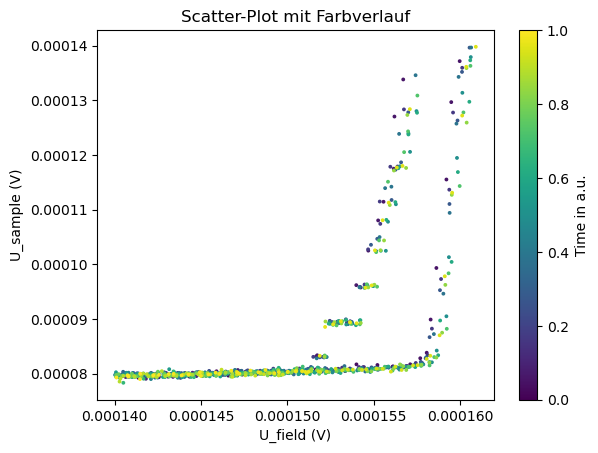

In [82]:
colors = np.linspace(0, 1, len(df_filtered))
#plt.plot(df_hc['U_field (V)'], df_hc['U_sample (V)'])
# Scatter-Plot mit Farbverlauf erstellen
plt.scatter(df_filtered['U_field (V)'], df_filtered['U_sample (V)'], c=colors, cmap='viridis', s=3)
plt.colorbar(label='Time in a.u.')  # Farbleiste hinzufügen
plt.xlabel('U_field (V)')
plt.ylabel('U_sample (V)')
plt.title('Scatter-Plot mit Farbverlauf')
plt.show()

C:\Users\lucas\AppData\Local\Temp\ipykernel_12632\3664858636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dU_sample'] = np.insert(dU_sample, 0, 0)


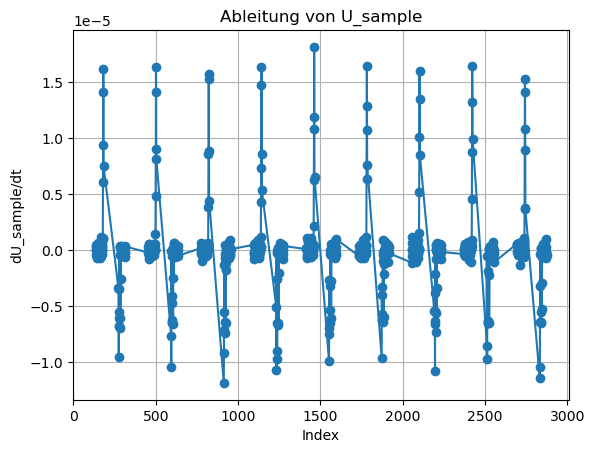

135     False
136     False
137     False
138     False
139     False
        ...  
2870    False
2871    False
2872    False
2873    False
2874    False
Name: dU_sample, Length: 846, dtype: bool


In [83]:
dU_sample = np.diff(df_filtered['U_sample (V)'])

# Da np.diff die Differenz der benachbarten Werte berechnet, müssen wir für das Plotten einen Wert für den ersten U_sample-Wert hinzufügen
# Hier fügen wir einfach den Wert 0 als ersten Wert der Ableitung hinzu
df_filtered['dU_sample'] = np.insert(dU_sample, 0, 0)

# Plotten der Ableitung gegen den Index
plt.plot(df_filtered.index, df_filtered['dU_sample'], marker='o')
plt.xlabel('Index')
plt.ylabel('dU_sample/dt')
plt.title('Ableitung von U_sample')
plt.grid(True)
plt.show()
indices = (df_filtered['dU_sample'] > 0.25) & (df_filtered['dU_sample'] < 1)
print(indices)

# Erstelle eine Liste mit 1 an den entsprechenden Stellen und 0 an den anderen
binary_list = np.where(indices, 1, 0)

In [ ]:
# Step 1: Finde die Indizes, bei denen 0.25 < dU_sample < 1 gilt
indices = (df_filtered['dU_sample'] > 0.25*10**(-5)) & (df_filtered['dU_sample'] < 1*10**(-5))

# Step 2: Erstelle eine Liste, die nur '1' bei den Indizes setzt, bei denen der Abstand zum letzten gefundenen Index mindestens 100 beträgt
# Apply the filter
filtered_df = df_filtered[indices]

# Plot U_sample (V) vs. U_field (V)
plt.scatter(filtered_df['U_field (V)'], filtered_df['U_sample (V)'], marker='o', label='Filtered Points')
plt.plot(df_filtered['U_field (V)'], df_filtered['U_sample (V)'], alpha =0.2)

# Add text annotations for each point
for x, y in zip(filtered_df['U_field (V)'], filtered_df['U_sample (V)']):
    plt.text(x, y, f"{x:.2e}", fontsize=9, verticalalignment='bottom', horizontalalignment='right')
plt.ylim(0.000086, 0.000092)  # Setzt die Grenzen der y-Achse
# Labels and title
plt.xlabel('U_field (V)')
plt.ylabel('U_sample (V)')
plt.title('Filtered U_sample vs. U_field')
plt.legend()
plt.grid(True)
plt.xlim(0.000155, 0.000160)  # Setzt die Grenzen der x-Achse

#plt.show()

### 4x 1.58*10(-4)
### 5x 1.59*10^(-4)

In [ ]:
csv_files.remove('Dils_Luca__30.csv') 

3


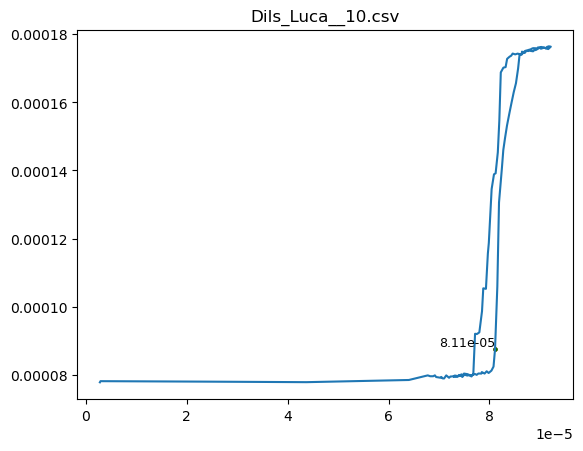

4


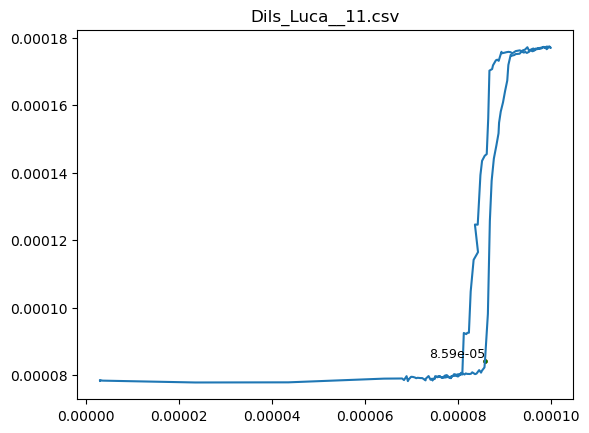

5


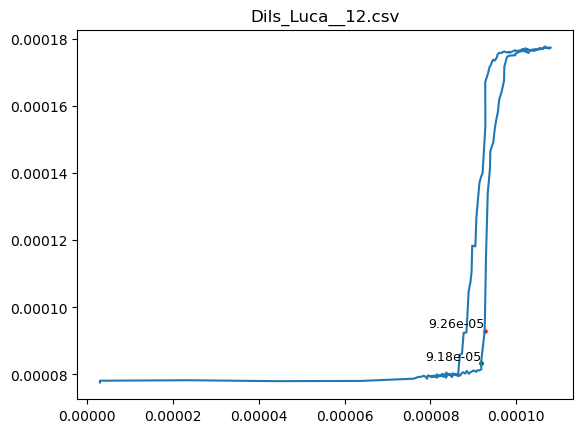

6


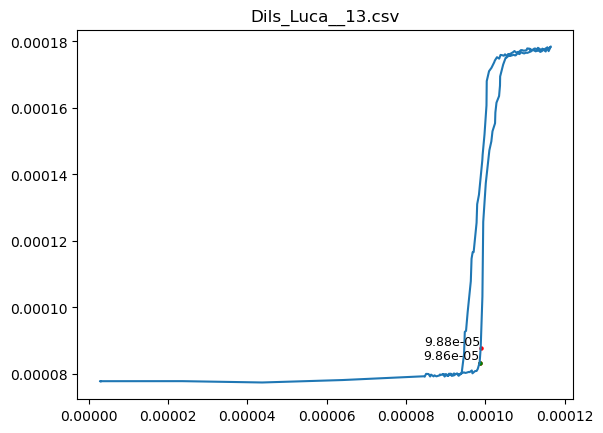

7


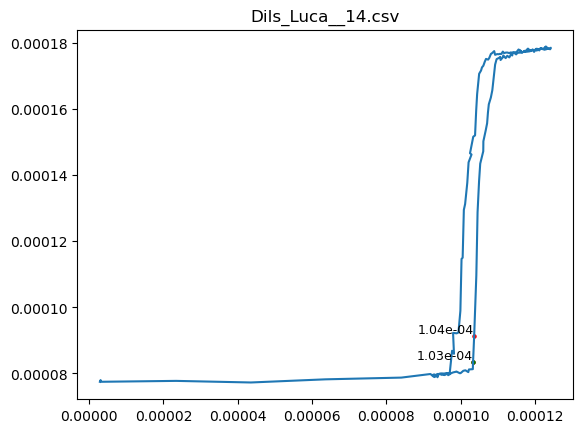

8


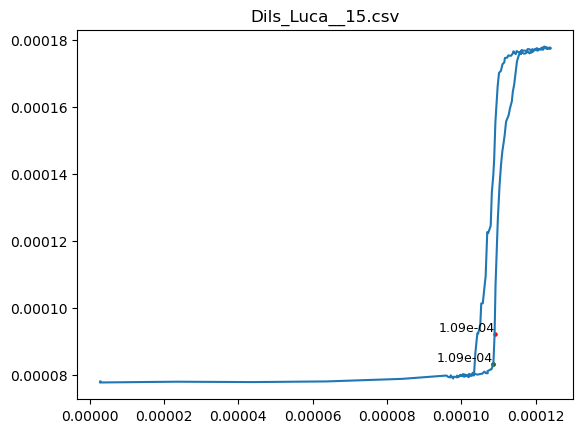

9


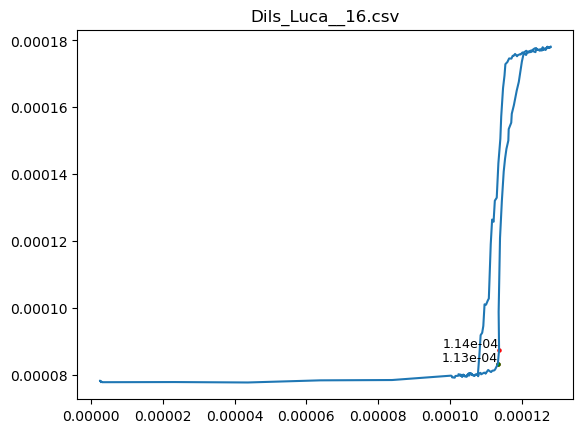

10


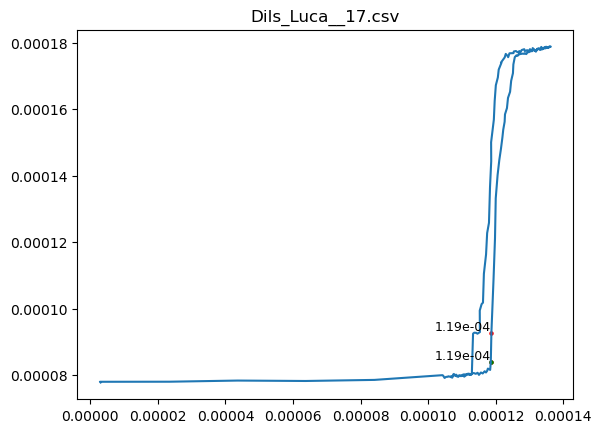

11


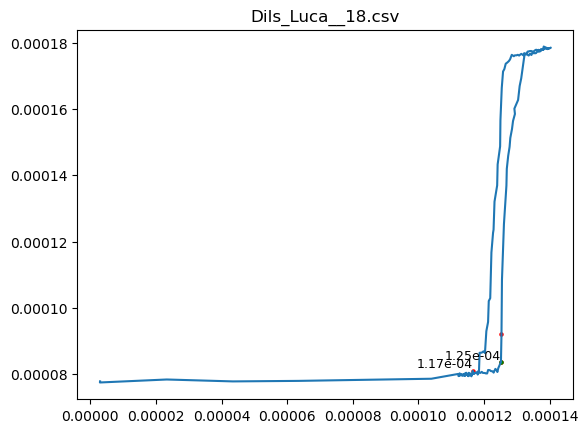

12


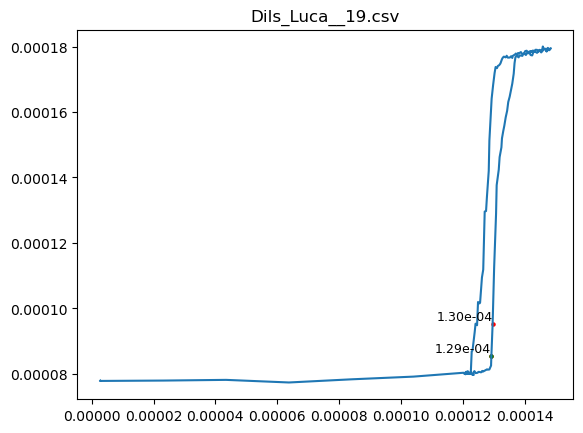

13


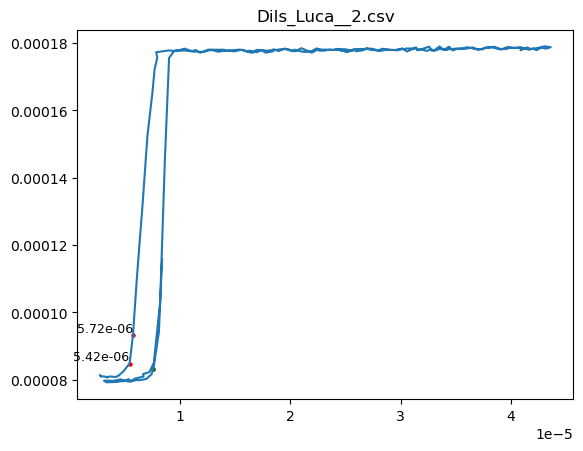

14


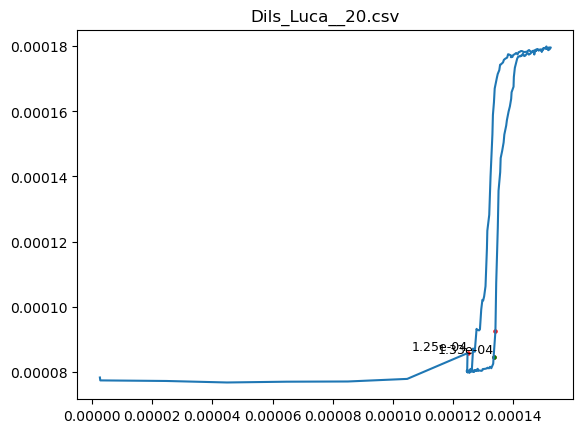

15


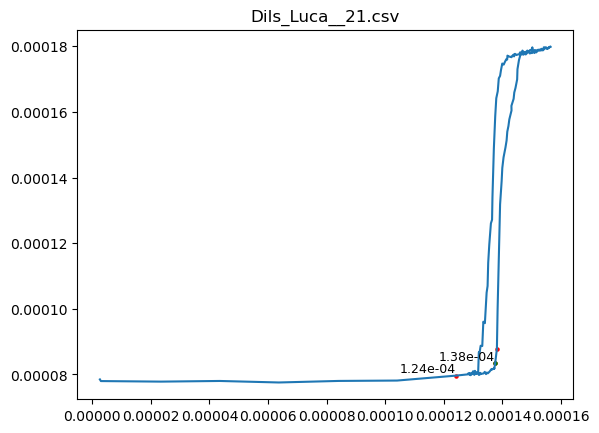

16


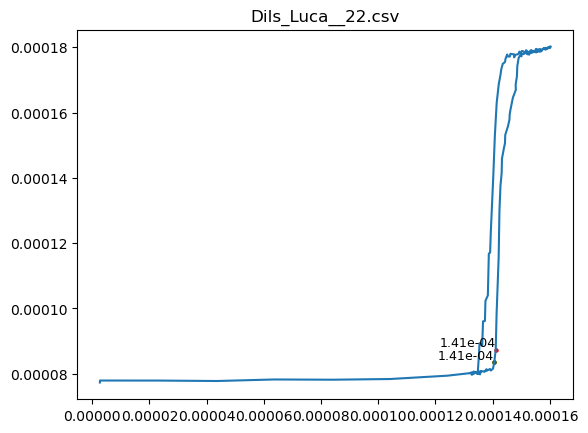

17


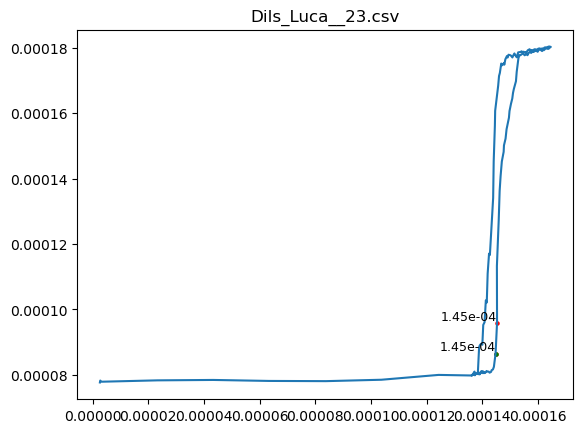

18


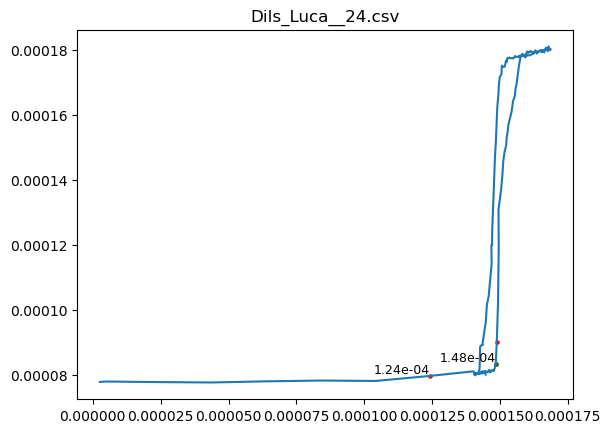

19


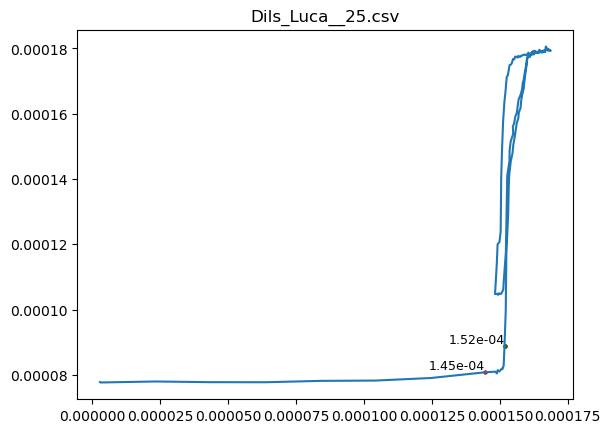

20


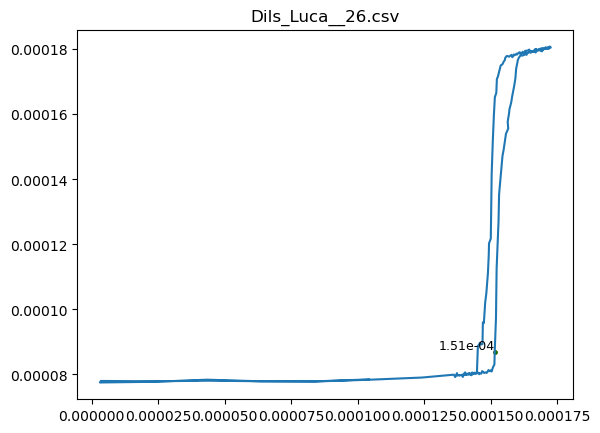

21


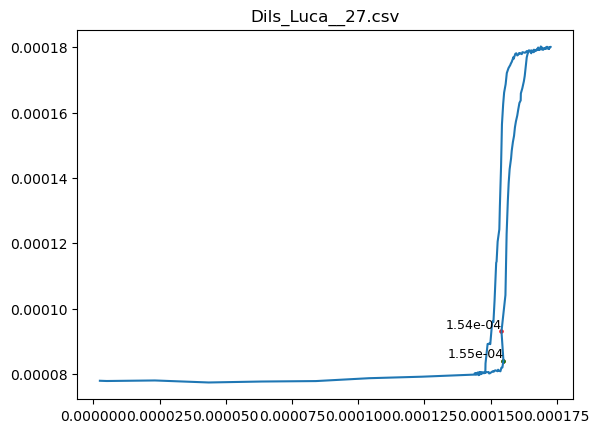

22


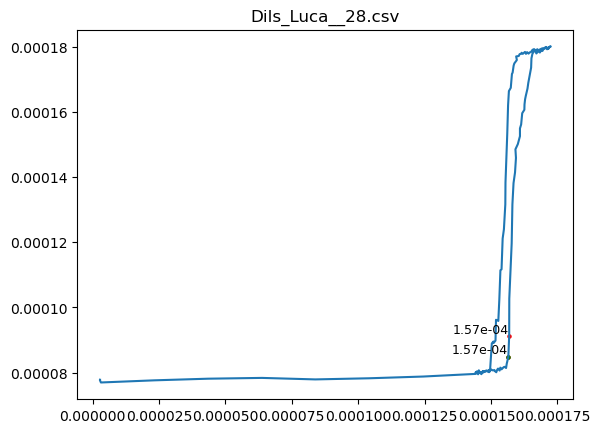

23


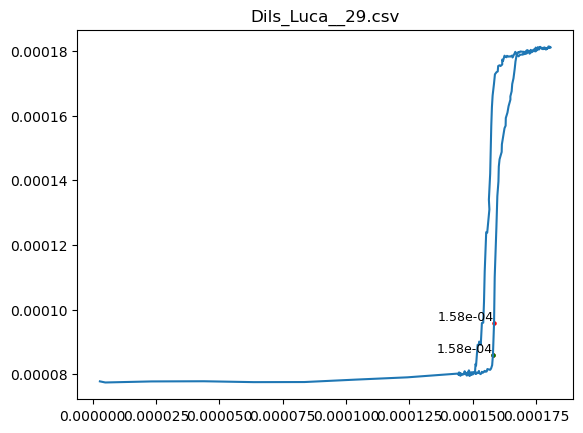

24
Dils_Luca__3.csv
25


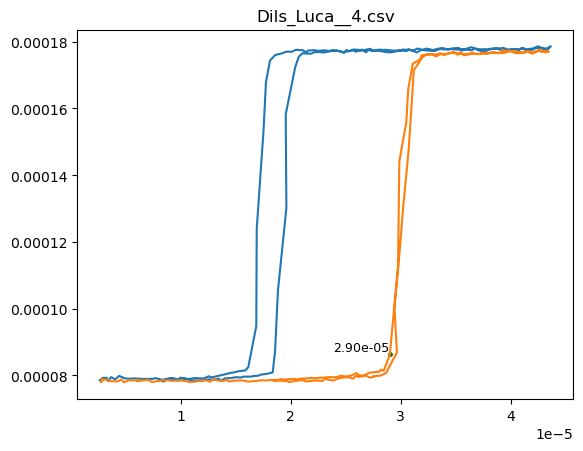

26


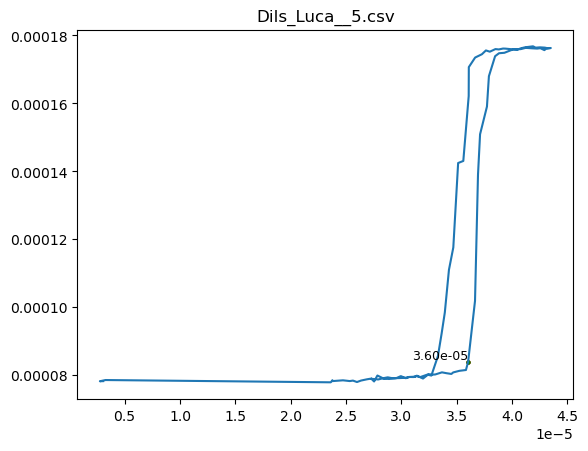

27


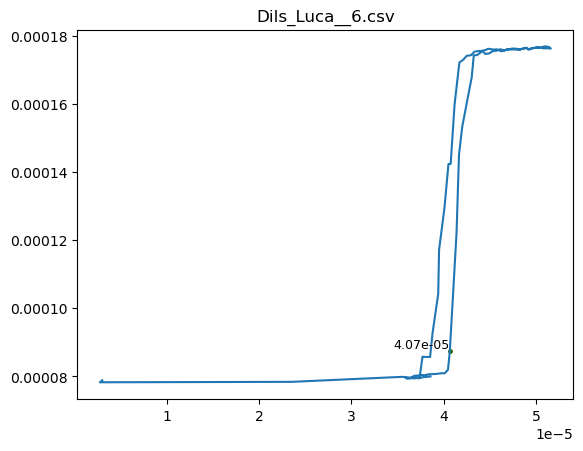

28


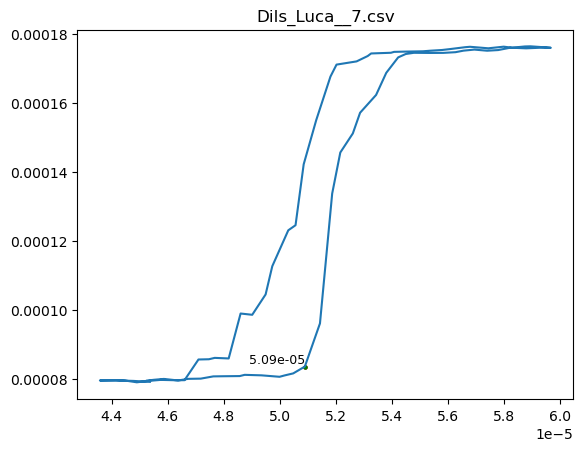

29


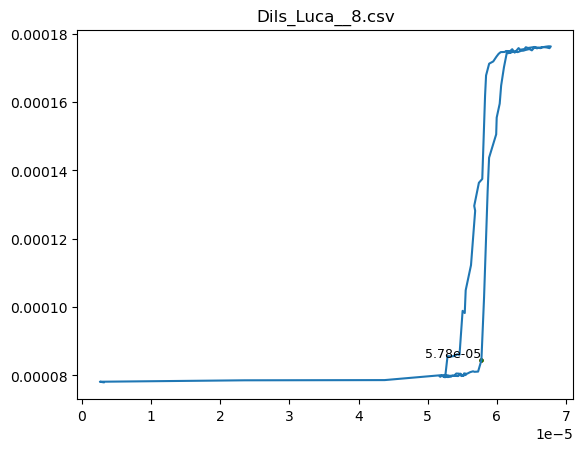

30


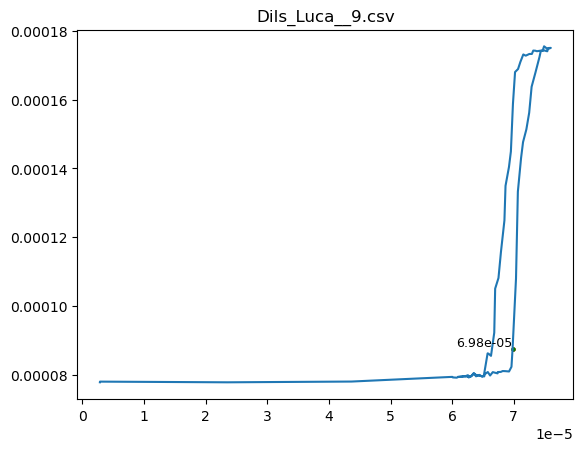

In [ ]:
df_hc_calc = pd.DataFrame()
position = [0,0,0,0,0,
            0,0,0,0,0,
            1,0,2,1,1,  
            0,0,1,1,0,
            0,0,0,0,0,
            0,0,0,0,0,]
 
for count, element in enumerate(csv_files[2:], start=2):
    try:
        print(count+1)
        df_hc = pd.read_csv('data_proprocessed_2/'+element)
        #print(element)
        dU_sample = np.diff(df_hc['U_sample (V)'])

        # Da np.diff die Differenz der benachbarten Werte berechnet, müssen wir für das Plotten einen Wert für den ersten U_sample-Wert hinzufügen
        # Hier fügen wir einfach den Wert 0 als ersten Wert der Ableitung hinzu
        df_hc['dU_sample'] = np.insert(dU_sample, 0, 0)
        indices = (df_hc['dU_sample'] > 0.15*10**(-5)) & (df_hc['dU_sample'] < 1*10**(-5))

        # Step 2: Erstelle eine Liste, die nur '1' bei den Indizes setzt, bei denen der Abstand zum letzten gefundenen Index mindestens 100 beträgt
        # Apply the filter
        filtered_df = df_hc[indices]
        indices_2 = (filtered_df['U_sample (V)'] < 0.0001)
        filtered_df = filtered_df[indices_2]
        plt.plot(df_hc['U_field (V)'], df_hc['U_sample (V)'])
    
        plt.scatter(filtered_df['U_field (V)'][0:5], filtered_df['U_sample (V)'][0:5], marker='o', s=5, c= 'red',label='Filtered Points')
    

        for x, y in zip(filtered_df['U_field (V)'][0:2], filtered_df['U_sample (V)'][0:2]):
            plt.text(x, y, f"{x:.2e}", fontsize=9, verticalalignment='bottom', horizontalalignment='right')
        selected_row = filtered_df.iloc[[position[count]]]
        plt.scatter(selected_row['U_field (V)'], selected_row['U_sample (V)'], marker='o', s=5, c= 'green',)
        plt.title(element)
        plt.show()
    


    # Append the row to df_hc_calc
        df_hc_calc = pd.concat([df_hc_calc, selected_row], ignore_index=True)
    except:
        print(element)
#df_hc = df_hc[df_hc['U_field (V)'] >= 0.00014]
##df_hc = df_hc[:200]
#df_hc.head()
#df_filtered = df_hc[df_hc['U_sample (V)'] < 0.00014]

## T_c